# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**The business objective is to understand which factors most influence the price of used cars. From a data perspective, this translates to a supervised regression problem, where the target variable is price and the predictors include vehicle characteristics, such as age, mileage, manufacturer, model, condition, fuel type, and transmission. The goal is to build a predictive model that quantifies the relationship between these features and price, allowing the dealership to identify key price drivers.**

**To that end: we note that such a study is important through the lens of the seller (the car dealership) for reasons related to (but not limited to): optimizing pricing (including demand forecasting), optimizing inventory, targeted marketing, trend spotting, and/or regional strategy.**

In [1]:
import plotly
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
##from sklearn.datasets import fetch_california_housing, load_diabetes, nile, fetch_openml

from statsmodels.tsa import arima_process
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
import statsmodels.api as sm
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.filters.filtertools import convolution_filter


from sklearn import set_config

set_config(display="diagram") #setting this will display your pipelines as seen above


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

**We start by obviously reading the dataset into the system. Then exploring the contents of said data.**

In [2]:
data = pd.read_csv('/Users/neelbardhan/Downloads/practical_application_II_starter/data/vehicles.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [3]:
data.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


**We then find how many unique values within each column there are. Gives you an idea of the variance of outcomes. Obviously the categorical ones like 'id' will be unique per value.**

In [4]:
# How many unique values - For all columns
for col in data.columns:
    unique_vals = data[col].nunique()
    print(f"{col}: {unique_vals} unique values")

id: 426880 unique values
region: 404 unique values
price: 15655 unique values
year: 114 unique values
manufacturer: 42 unique values
model: 29649 unique values
condition: 6 unique values
cylinders: 8 unique values
fuel: 5 unique values
odometer: 104870 unique values
title_status: 6 unique values
transmission: 3 unique values
VIN: 118246 unique values
drive: 3 unique values
size: 4 unique values
type: 13 unique values
paint_color: 12 unique values
state: 51 unique values


In [5]:
data.shape

(426880, 18)

In [6]:
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [7]:
exclude_cols = ['id', 'region', 'price', 'year', 'model', 'odometer', 'VIN']

for col in data.columns:
    if col not in exclude_cols:
        print(f"Column: {col}")
        print(data[col].unique())
        print("-" * 40)
##shows what the unique values are for columns, excluding the ones we don't want to include
##we don't want to include these because they're identifiers, or simply because they have too many values

Column: manufacturer
[nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'ferrari' 'mini' 'pontiac' 'fiat' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan']
----------------------------------------
Column: condition
[nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']
----------------------------------------
Column: cylinders
[nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
----------------------------------------
Column: fuel
[nan 'gas' 'other' 'diesel' 'hybrid' 'electric']
----------------------------------------
Column: title_status
[nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
----------------------------------------
Column

**While scrolling through the dataset, I notice quite a few entries are blank. We seem to have a missing data problem. Let's take a look at what data is missing.**

In [8]:
# missing_values = data.isnull().sum()

# missing_values = missing_values.sort_values(ascending=False)

# missing_values.plot(kind='bar', color='blue')
# plt.title("Missing Values per Column", fontsize=16)
# plt.ylabel("Number of Missing Values", fontsize=16)
# plt.xticks(rotation=45, ha='right')
# plt.show()

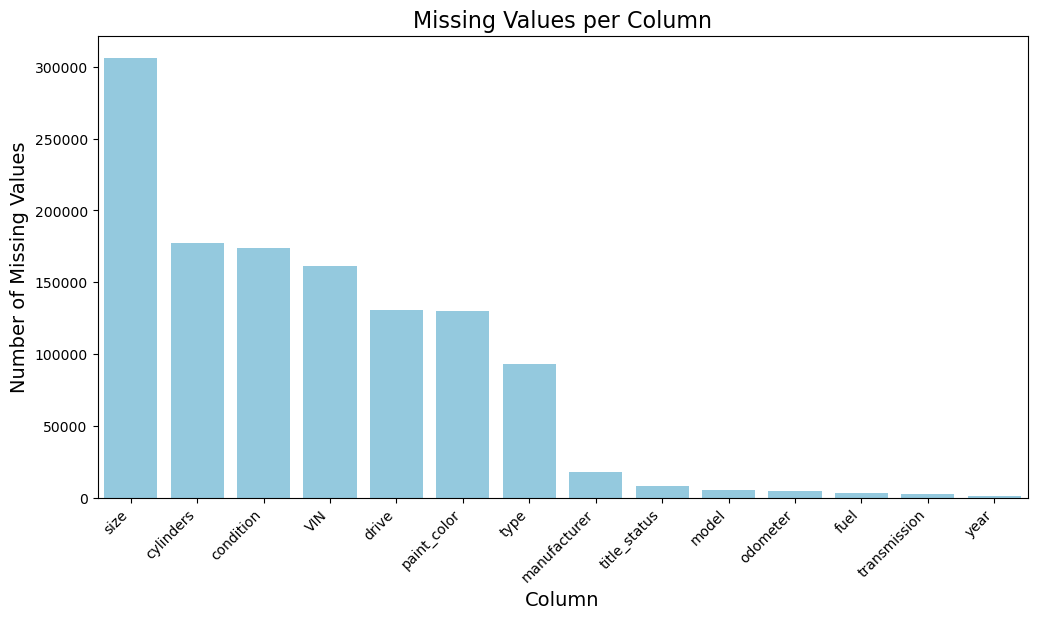

In [9]:
# Count missing values
missing_counts = data.isnull().sum().reset_index()
missing_counts.columns = ['column', 'missing_count']

# Only keep columns with at least 1 missing value
missing_counts = missing_counts[missing_counts['missing_count'] > 0]

# Sort by missing_count (descending)
missing_counts = missing_counts.sort_values(by="missing_count", ascending=False)

# Plot with seaborn
plt.figure(figsize=(12,6))
sns.barplot(x="column", y="missing_count", data=missing_counts, color="skyblue")

plt.title("Missing Values per Column", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Missing Values", fontsize=14)
plt.xlabel("Column", fontsize=14)
plt.show()

**From this, it's becoming clear that we're gonna have to drop some columns. Either due to them being irrelevant to the idea of price (which we're exploring as our response/predicted variable), such as id or VIN, or because they're missing so many values that it's not feasible to do any meaningful analysis with such limited data. I suppose you could fill the missing values for some of them with dummy data (e.g. average/median of the dataset), but we'll explore this later. This is all related to business understanding because now we're starting to weed out what values aren't relevant to this analysis.**

**For ones like odometer, price and maybe even model, it may be worth looking into to see if we can stratify them by range (e.g. odometer from 0 to 25k miles being one range, 25k to 50k miles being another, etc.) - perhaps something like One Hot Encoding?**

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

**Now we have to start cleaning the data here. We'll start by dropping columns I deem to be irrelevant. Then we'll continue by either filling in missing values with placeholder/dummies, or otherwise deciding what to do. I'll also have to make optimization decisions (e.g. computational complexity, is it worth keeping X column if Y column does 90% of the same thing?)**

In [10]:
# Dropping these because they have no influence over buying decisions
data_cleaned = data.drop(['id', 'VIN','region', 'model', 'size'], axis = 1)


**Are you really going to decide to buy/sell a car based on its VIN or id?**

**Dropping region because it's far too granular (hundreds of unique values). Having too many categories can make modeling messy without adding much value (Chicago vs. “North Suburbs of Chicago” usually won’t affect price that much). State already captures the location signal, so you can safely drop region. On top of that, some region values aren’t clean (e.g., “South Florida” vs. “Miami”), which makes encoding messy and inconsistent.**

**Model the same idea - this can be covered by manufacturer (Honda) and type (truck). Size is dropped because it's mostly a missing dataset altogether as we saw earlier. A column isn't of much use to us if most of it is missing data.**

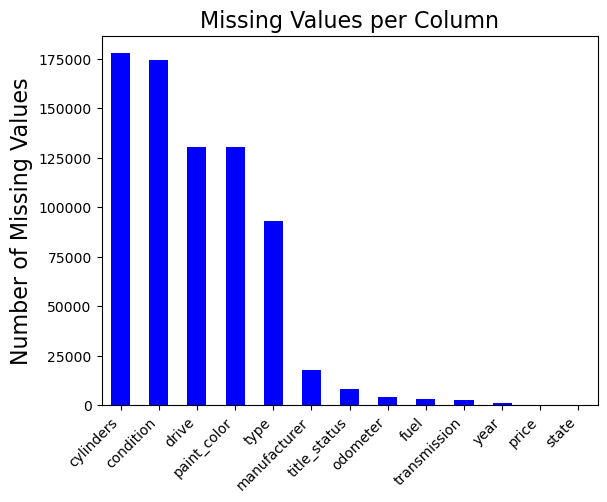

In [11]:
# Now take a look again - seems to be 5 data columns we now need to decide what to do with, as they all have ~ 100k or more missing values

cleaned_missing_values = data_cleaned.isnull().sum()

cleaned_missing_values = cleaned_missing_values.sort_values(ascending=False)

cleaned_missing_values.plot(kind='bar', color='blue')
plt.title("Missing Values per Column", fontsize=16)
plt.ylabel("Number of Missing Values", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

**From this we can see that we still have a decent amount of missing values from the 5 columns 'cylinders', 'condition', 'drive', 'paint_color', 'type'. The other ones have missing values of significantly less scale so I'm comfortable keeping those in. However, given those 5 are ones I deem to be important to the analysis, I'd rather not drop them. Now it's time to evaluate options of what to do with them.**

In [12]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   condition     252776 non-null  object 
 4   cylinders     249202 non-null  object 
 5   fuel          423867 non-null  object 
 6   odometer      422480 non-null  float64
 7   title_status  418638 non-null  object 
 8   transmission  424324 non-null  object 
 9   drive         296313 non-null  object 
 10  type          334022 non-null  object 
 11  paint_color   296677 non-null  object 
 12  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 42.3+ MB


In [13]:
data_cleaned_filled = data_cleaned.copy()
##creating a copy of the cleaned dataset without overwriting the original data_cleaned

In [14]:
categorical_cols = data_cleaned_filled.select_dtypes(include='object').columns
data_cleaned_filled[categorical_cols] = data_cleaned_filled[categorical_cols].fillna('unknown')

In [15]:
data_cleaned_filled.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,6000,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,unknown,unknown,unknown,az
1,11900,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,unknown,unknown,unknown,ar
2,21000,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,unknown,unknown,unknown,fl
3,1500,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,unknown,unknown,unknown,ma
4,4900,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,unknown,unknown,unknown,nc


In [16]:
data_cleaned['title_status'].value_counts(dropna=False)
data_cleaned_filled['title_status'].value_counts(dropna=False)

title_status
clean         405117
unknown         8242
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: count, dtype: int64

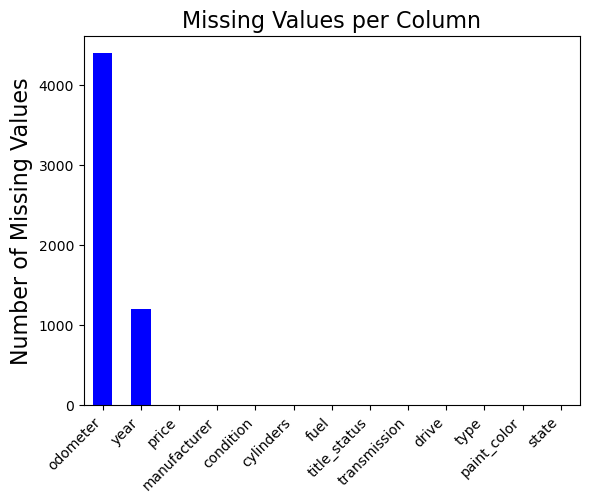

In [17]:
##now check if the missing values have been filled
cleaned_missing_values_filled = data_cleaned_filled.isnull().sum()

cleaned_missing_values_filled = cleaned_missing_values_filled.sort_values(ascending=False)

cleaned_missing_values_filled.plot(kind='bar', color='blue')
plt.title("Missing Values per Column", fontsize=16)
plt.ylabel("Number of Missing Values", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

**If year is missing ~1,200 rows and odometer ~4,400 rows out of 426,000(ish), I'm losing about 1% of the data at most if you drop them. That’s absolutely nothing in exchange for keeping two of the most powerful predictors. Therefore I'm dropping the observations which have missing values for odometer and year.**

In [18]:
data_cleaned_filled = data_cleaned_filled.dropna(subset=['year', 'odometer'])
data_cleaned_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421344 entries, 27 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         421344 non-null  int64  
 1   year          421344 non-null  float64
 2   manufacturer  421344 non-null  object 
 3   condition     421344 non-null  object 
 4   cylinders     421344 non-null  object 
 5   fuel          421344 non-null  object 
 6   odometer      421344 non-null  float64
 7   title_status  421344 non-null  object 
 8   transmission  421344 non-null  object 
 9   drive         421344 non-null  object 
 10  type          421344 non-null  object 
 11  paint_color   421344 non-null  object 
 12  state         421344 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 45.0+ MB


In [19]:
data_cleaned_filled.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,33590,2014.0,gmc,good,8 cylinders,gas,57923.0,clean,other,unknown,pickup,white,al
28,22590,2010.0,chevrolet,good,8 cylinders,gas,71229.0,clean,other,unknown,pickup,blue,al
29,39590,2020.0,chevrolet,good,8 cylinders,gas,19160.0,clean,other,unknown,pickup,red,al
30,30990,2017.0,toyota,good,8 cylinders,gas,41124.0,clean,other,unknown,pickup,red,al
31,15000,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al


In [20]:
data_cleaned_filled.tail()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
426875,23590,2019.0,nissan,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy
426876,30590,2020.0,volvo,good,unknown,gas,12029.0,clean,other,fwd,sedan,red,wy
426877,34990,2020.0,cadillac,good,unknown,diesel,4174.0,clean,other,unknown,hatchback,white,wy
426878,28990,2018.0,lexus,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy
426879,30590,2019.0,bmw,good,unknown,gas,22716.0,clean,other,rwd,coupe,unknown,wy


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [21]:
##define target (X) and features (y)
X = data_cleaned_filled.drop(columns=['price'])   # features
y = data_cleaned_filled['price']                  # target

**Remember that not all of the data here is numeric - some are categorical so need to be handled accordingly.**

In [22]:
X_encoded = pd.get_dummies(X)
X_encoded = X_encoded.replace({True: 1, False: 0})

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X_train, y_train) #fitting the training data to a linear regression

LinearRegression(fit_intercept=False)

In [23]:
linreg.coef_

# X_train.columns contains all your feature names
coefs = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': linreg.coef_
})

# Optional: sort by magnitude to see biggest drivers
coefs = coefs.reindex(coefs.coefficient.abs().sort_values(ascending=False).index)

print(coefs.head(20))  # top 20 strongest features

                        feature   coefficient
117                    state_de  3.917845e+06
46               condition_fair  1.102826e+06
78                    drive_4wd  8.299344e+05
76           transmission_other  7.684870e+05
75          transmission_manual  7.559159e+05
100           paint_color_green  7.554615e+05
79                    drive_fwd  7.464079e+05
28   manufacturer_mercedes-benz  7.238055e+05
77         transmission_unknown  7.184762e+05
74       transmission_automatic  7.019996e+05
81                drive_unknown  7.004692e+05
80                    drive_rwd  6.680671e+05
73         title_status_unknown  5.823954e+05
67           title_status_clean  5.694306e+05
65                   fuel_other  5.663651e+05
62                fuel_electric  5.390362e+05
71         title_status_rebuilt  5.318943e+05
63                     fuel_gas  5.198098e+05
68            title_status_lien  5.185664e+05
44           manufacturer_volvo  5.064777e+05


In [24]:
pd.set_option('display.max_columns', None)
X_encoded.head()

,year,odometer,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_unknown,manufacturer_volkswagen,manufacturer_volvo,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,condition_unknown,cylinders_10 cylinders,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,cylinders_unknown,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,fuel_unknown,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,title_status_unknown,transmission_automatic,transmission_manual,transmission_other,transmission_unknown,drive_4wd,drive_fwd,drive_rwd,drive_unknown,type_SUV,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_unknown,type_van,type_wagon,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_unknown,paint_color_white,paint_color_yellow,state_ak,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
27,2014.0,57923.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,2010.0,71229.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,2020.0,19160.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30,2017.0,41124.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31,2013.0,128000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

**Now we add a baseline train/test array and calculate the MSE of both such that we have a baseline to compare our models to.**

**In essence - predicting the mean of the training set price for every car.**

In [39]:
baseline_pred_train = np.ones_like(y_train) * y_train.mean()
baseline_pred_test = np.ones_like(y_test) * y_train.mean()  # note: use train mean! we ain't gotta clue what the test dataset outcomes are

baseline_mse_train = mean_squared_error(y_train, baseline_pred_train)
baseline_mse_test = mean_squared_error(y_test, baseline_pred_test)

print("Baseline MSE (train):", baseline_mse_train)
print("Baseline MSE (test):", baseline_mse_test)

Baseline MSE (train): 182001920759661.2
Baseline MSE (test): 23780757137480.79


In [41]:
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)

linreg_mse_train = mean_squared_error(y_train, y_pred_train)
linreg_mse_test = mean_squared_error(y_test, y_pred_test)

print("Linear Regression MSE (train):", linreg_mse_train)
print("Linear Regression MSE (test):", linreg_mse_test)

Linear Regression MSE (train): 181888383696483.25
Linear Regression MSE (test): 23846276162550.402


In [27]:
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)
print("Train R²:", r2_train)
print("Test R²:", r2_test)

Train MSE: 181881213247902.94
Test MSE: 23910955597097.824
Train RMSE: 13486334.314701788
Test RMSE: 4889882.983988249
Train R²: 0.0006632210871976296
Test R²: -0.0055807653173369776


In [28]:
print(baseline_mse_test - mse_test)

-130198459617.03516


**This shows the test MSE for the Linear Regression Model is actually worse than the baseline model! That's surprising. If the baseline test MSE was higher, I think that would've been the expected outcome.**

**Let's now see which features (variables) have strongest links to price determination. Mind you - this isn't scaled, so coefficient values will be off. It's still useful as it tells what variables are more correlated and more highly linked, just not the exact scope of how much.**

In [29]:
linreg = LinearRegression().fit(X_encoded, y)

# Get coefficients
coefs = linreg.coef_

# Get the column names
features = X_encoded.columns

# Combine into a DataFrame for easy viewing
coef_df = pd.DataFrame({'feature': features, 'coefficient': coefs})

# Sort by absolute value to see which ones matter most
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)
coef_df.head(20)  # top 20 most important features

,feature,coefficient,abs_coef
117,state_de,3.085760e+06,3.085760e+06
46,condition_fair,5.305407e+05,5.305407e+05
28,manufacturer_mercedes-benz,5.272814e+05,5.272814e+05
100,paint_color_green,4.135026e+05,4.135026e+05
44,manufacturer_volvo,3.539244e+05,3.539244e+05
151,state_tn,2.666056e+05,2.666056e+05
70,title_status_parts only,-2.536403e+05,2.536403e+05
69,title_status_missing,-2.316874e+05,2.316874e+05
88,type_offroad,-2.302312e+05,2.302312e+05
11,manufacturer_datsun,-2.282976e+05,2.282976e+05


**From here we see factor like Cars being sold in the state of Delaware (DE) have a bigger impact in price, as well as certain manufacturers like Mercedes Benz. You'll notice that depending on whether the coefficient is negative or positive, it impacts the price accordingly. E.g. if you see column title_status_parts only you'll see it has a negative correlation, so it strongly impacts price such that it actually has a negative correlation and decreases price (which makes sense).**

**Given we're trying to optimize features (feature selection) I'll compare it to a Lasso regression model (ignoring Ridge regression - which keeps all features), next.**

In [30]:
# # Split features/target
# X = data_cleaned_filled.drop(columns=['price'])
# y = data_cleaned_filled['price']

# # Numeric & categorical columns
# numeric_cols = ['year', 'odometer']
# categorical_cols = ['manufacturer', 'condition', 'cylinders', 'fuel', 
#                     'title_status', 'transmission', 'drive', 'type', 
#                     'paint_color', 'state']

# # Train/test split
# lasso_X_train, lasso_X_test, lasso_y_train, lasso_y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

In [31]:
# Columns are all numeric now
lasso_pipe = Pipeline([
   ## ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # not using polynomial features because most of the data is categorical
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

lasso_pipe.fit(X_train, y_train)
lasso_coefs_ = lasso_pipe.named_steps['lasso'].coef_

In [32]:
# Define hyperparameters to search
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1, 10]  # tune this as needed
}

# grid = GridSearchCV(lasso_pipe, param_grid, cv=5, scoring='r2')
# grid.fit(X_train, y_train)

# print("Best alpha:", grid.best_params_['lasso__alpha'])
# print("Best CV score:", grid.best_score_)

# # Evaluate on test set
# lasso_test_mse = mean_squared_error(y_test, grid.predict(X_test))
# print(lasso_test_mse)

In [33]:
# YOUR CODE HERE
lasso_train_mse = mean_squared_error(y_train, lasso_pipe.predict(X_train))
lasso_test_mse = mean_squared_error(y_test, lasso_pipe.predict(X_test))

##you have to use auto_pipe.predict() to compared predictions to actual, instead of features to actual

# Answer check
print(lasso_train_mse)
print(lasso_test_mse)

181881213248051.6
23910951149192.336


In [37]:
print(baseline_mse_test - lasso_test_mse)
print(lasso_test_mse - mse_test)

-130194011711.54688
-4447905.48828125


In [43]:
# Get the column names from your training data
features = X_train.columns  

# Combine into DataFrame
lasso_coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': lasso_coefs_
})

# Add absolute value column for sorting
lasso_coef_df['abs_coef'] = lasso_coef_df['coefficient'].abs()

# Sort by absolute value of coefficients
lasso_coef_df = lasso_coef_df.sort_values(by='abs_coef', ascending=False)

# Look at top 20
lasso_coef_df.head(20)

,feature,coefficient,abs_coef
117,state_de,186034.055858,186034.055858
1,odometer,142740.308062,142740.308062
28,manufacturer_mercedes-benz,105804.079923,105804.079923
46,condition_fair,96253.803026,96253.803026
100,paint_color_green,71832.181124,71832.181124
151,state_tn,64442.240670,64442.240670
93,type_unknown,61666.465454,61666.465454
78,drive_4wd,58428.412782,58428.412782
82,type_SUV,-55624.467805,55624.467805
41,manufacturer_toyota,49963.872688,49963.872688


In [34]:
#GridSearchCV for cross-validation
grid = GridSearchCV(lasso_pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Best model and alpha
best_lasso = grid.best_estimator_
print("Best alpha:", grid.best_params_)

# Evaluate
y_pred_train = best_lasso.predict(X_train)
y_pred_test = best_lasso.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

print("Train R²:", r2_score(y_train, y_pred_train))
print("Test R²:", r2_score(y_test, y_pred_test))
print("Train RMSE:", mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))

# Get coefficients
lasso_coefs = best_lasso.named_steps['lasso'].coef_

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [ ]:
**In Summary

SyntaxError: invalid syntax (2789484092.py, line 1)